In [1]:
# Importing Necessary Packages
!pip install tensorflow==2.10.0
!pip install opendatasets
import os
import numpy as np 
import random as rn
import pandas as pd
from os import listdir
import tensorflow as tf
import opendatasets as od
from google.colab import files

# Image related libraries
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Libraries for Plotting Performance
from sklearn import metrics 
from sklearn.metrics import accuracy_score

# Libraries for Plotting visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Libraries for model Building and Training
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
 
# Downloading Dataset from Kaggle
od.download(
    "https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 110.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorfl

100%|██████████| 612M/612M [00:17<00:00, 36.9MB/s]


In [2]:
# Function for Plotting the performace of a model
def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('*************************MODEL ACCURACY*****************************\n')
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('*****************************MODEL LOSS*********************************\n')
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")
    plt.show()

In [3]:
# Function for predicting the test data
def predict_test_data(model):

  # Importing the test dataset
  test = pd.read_csv('/content/gtsrb-german-traffic-sign/Test.csv')

  labels = test["ClassId"].values
  imgs = test["Path"].values

  test_data=[]

  # Retreiving the images & Resizing images
  with tf.device('/GPU:0'):
      for img in imgs:
          image = Image.open('/content/gtsrb-german-traffic-sign/'+img)
          image = image.resize([32, 32])
          test_data.append(np.array(image))

  X_test_data = np.array(test_data)
  with tf.device('/GPU:0'):
      pred = np.argmax(model.predict(X_test_data), axis=-1)

  # Accuracy with the test data
  print('************************************Model Accuracy*******************************************')
  print(accuracy_score(labels, pred))

In [4]:
# Function to test on the image
def test_on_img(img, trained_model):
    data=[]
    model = trained_model
    image = Image.open(img)
    image = image.resize((32,32))
    data.append(np.array(image))
    X_test=np.array(data)
    Y_pred = np.argmax(model.predict(X_test), axis=1)
    return image,Y_pred

Found 39209 images belonging to 43 classes.
************************************Sample Images*******************************************


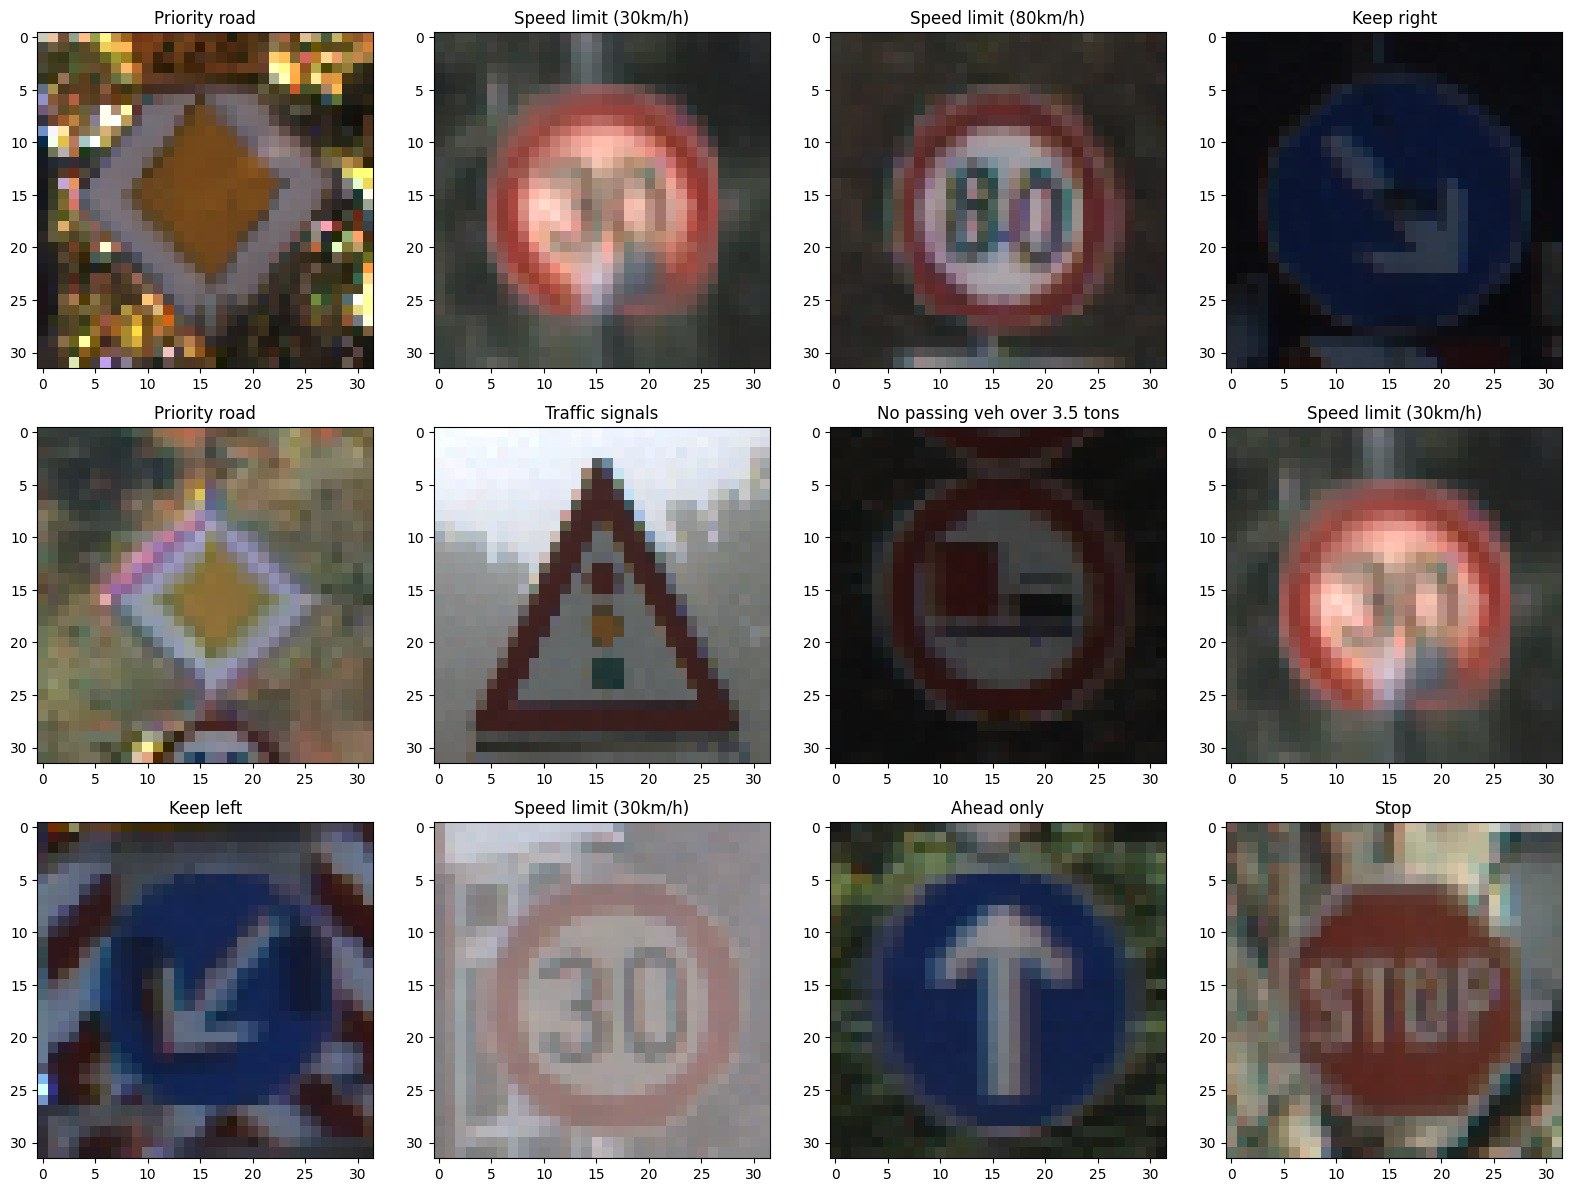

In [10]:
# Displaying sample images of the Dataset
train_path = '../content/gtsrb-german-traffic-sign/Train/'
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)
train_dataset = train_datagen.flow_from_directory(train_path,
                                                  target_size=(32, 32),
                                                  class_mode='categorical')
# Plotting the sample images
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
img,y = train_dataset.next()
for i in range(3):
    for j in range (4):
        l=rn.randint(0, 32-1)
        label = classes[int(list(train_dataset.class_indices.keys())[np.argmax(y[l])])]
        ax[i,j].imshow(img[l])
        ax[i,j].set_title(label)
print('************************************Sample Images*******************************************')
plt.tight_layout()

In [6]:
# Obtaining the data from the dataset
data = []
labels = []
classes = 43
cur_path = os.getcwd()

# Retrieving the images data and their labels into lists
for i in range(classes):
    path = os.path.join('/content/gtsrb-german-traffic-sign','train',str(i))
    images = os.listdir(path)

    for j in images:
        try:
            image = Image.open(path + '/'+ j)
            image = image.resize((32, 32))
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")

# Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)

print('***********************************************Original Data Shape*************************************************')
print(data.shape, labels.shape)

# Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Displaying the shape after the split
print('********************************************Shape after spilitting Data********************************************')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

***********************************************Original Data Shape*************************************************
(39209, 32, 32, 3) (39209,)
********************************************Shape after spilitting Data********************************************
(31367, 32, 32, 3) (7842, 32, 32, 3) (31367,) (7842,)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 32)        25632     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 8, 8, 32)          0         
                                                        

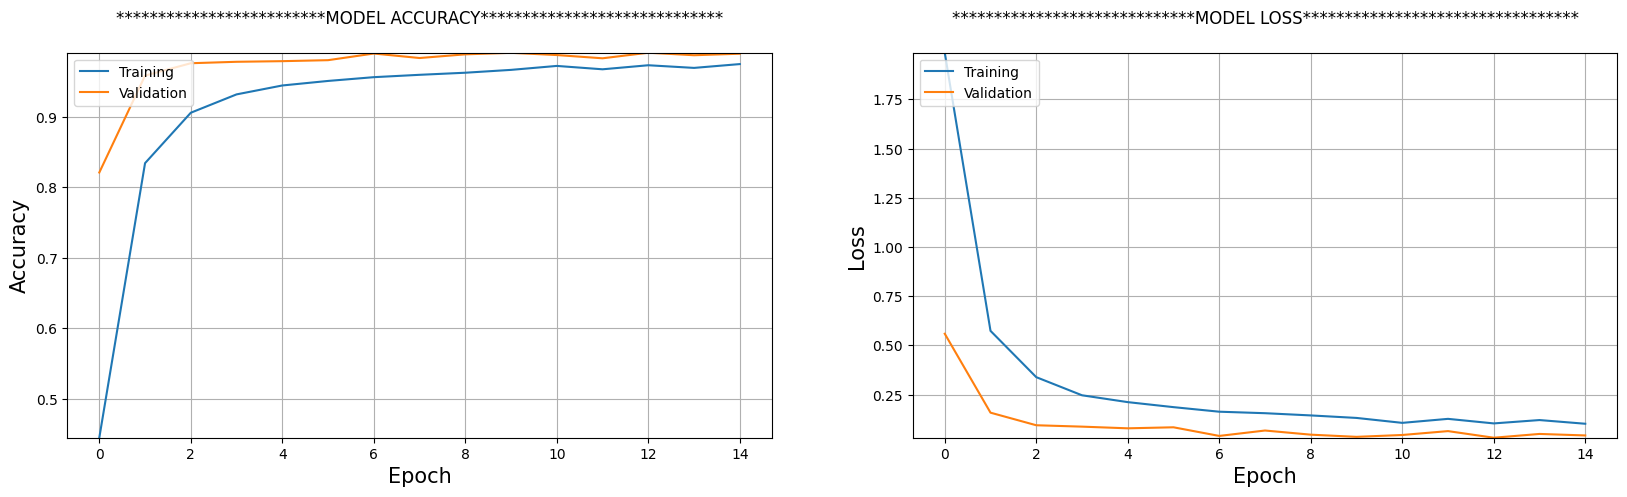

395/395 [==============================] - 1s 3ms/step
************************************Model Accuracy*******************************************
0.9517814726840855


In [7]:
# Building the CNN model
model = tf.keras.models.Sequential([
 tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]),
 tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]),
 tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
 tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu'),
 tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
 tf.keras.layers.Dropout(rate=0.25),
 tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
 tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
 tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
 tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
 tf.keras.layers.Dropout(rate=0.25),
 tf.keras.layers.Flatten(),
 tf.keras.layers.Dense(256, activation='relu'),
 tf.keras.layers.Dropout(0.5),
 tf.keras.layers.Dense(43, activation='softmax')
])
# Compilation of model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model Overview
model.summary()

# Training(Fitting) the Model
with tf.device('/GPU:0'):
    epochs = 15
    cnn_history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))

# Calling function to plot the performance of the model
plot_performance(history = cnn_history)
predict_test_data(model)

In [8]:
# Saving & Downloading the Model
model.save('cnn_classifier.h5')
files.download('cnn_classifier.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 33ms/step
************************************************CNN Model*****************************************************
Predicted traffic sign is:  Turn right ahead


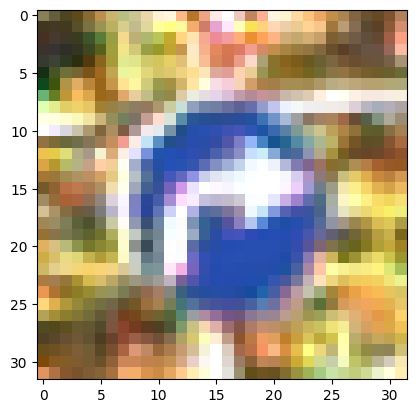

In [11]:
# Calling function to test the image
plot, prediction = test_on_img(r'/content/gtsrb-german-traffic-sign/Test/00003.png', model)
s = [str(i) for i in prediction] 
a = int("".join(s)) 
print("************************************************CNN Model*****************************************************")
print("Predicted traffic sign is: ", classes[a])
plt.imshow(plot)
plt.show()

80134624/80134624 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 batch_normalization (BatchN  (None, 1, 1, 512)        2048      
 ormalization)                                                   
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 43)                22059     
                                                                 
Total params: 20,311,147
Trainable params: 20,310,123
N

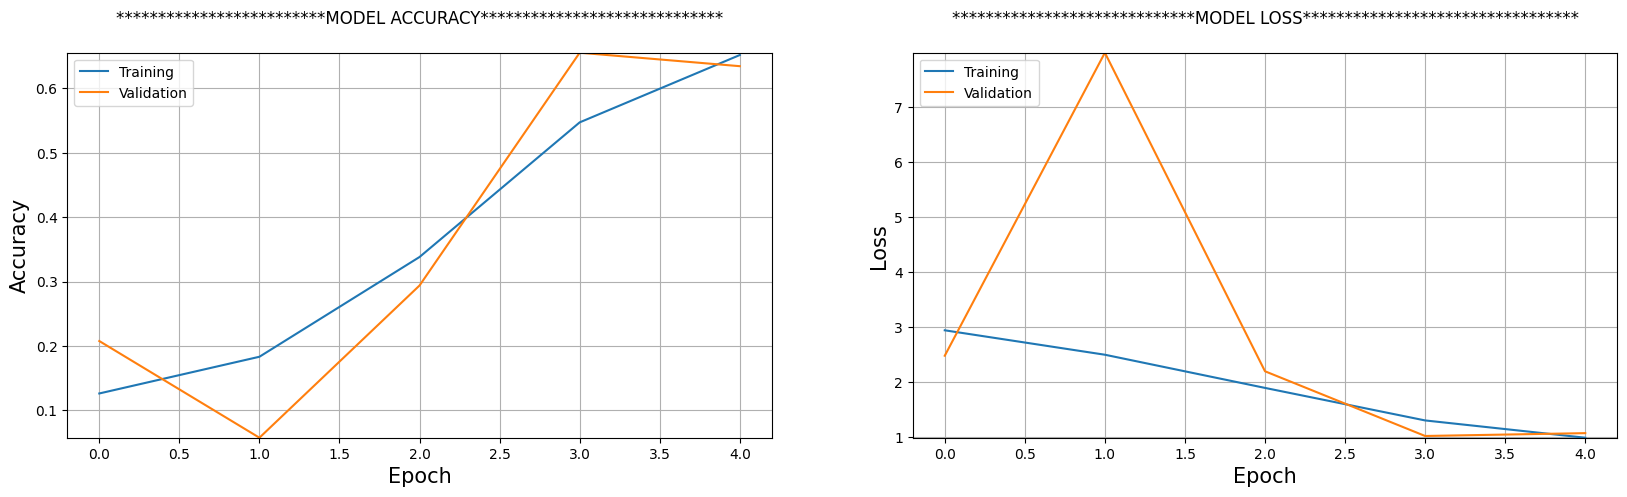

395/395 [==============================] - 4s 9ms/step
************************************Model Accuracy*******************************************
0.5892319873317498


In [12]:
# Building the VGG19 model
vgg_model = tf.keras.Sequential([VGG19(weights='imagenet', include_top=False, input_shape=X_train.shape[1:]),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(512, activation='sigmoid'),
                                 tf.keras.layers.Dense(43, activation='softmax')
                                ])

# Compilation of model
alpha=0.001
optim = tf.keras.optimizers.Adam(learning_rate=alpha)
vgg_model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Model Overview
vgg_model.summary()

# Training(Fitting) the Model
with tf.device('/GPU:0'):
    epochs = 5
    vgg_history = vgg_model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))
plot_performance(history = vgg_history)
predict_test_data(vgg_model)

1/1 [==============================] - 0s 335ms/step
******************************************VGG19 Model*********************************************************
Predicted traffic sign is:  Road work


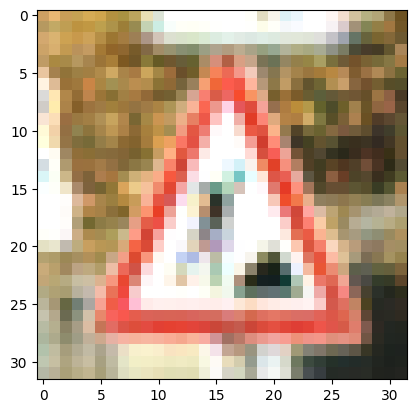

In [13]:
# Calling function to test the image
plot, prediction = test_on_img(r'/content/gtsrb-german-traffic-sign/Test/00008.png', vgg_model)
s = [str(i) for i in prediction] 
a = int("".join(s))
print("******************************************VGG19 Model*********************************************************") 
print("Predicted traffic sign is: ", classes[a])
plt.imshow(plot)
plt.show()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1, 1, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                81984     
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 43)                27

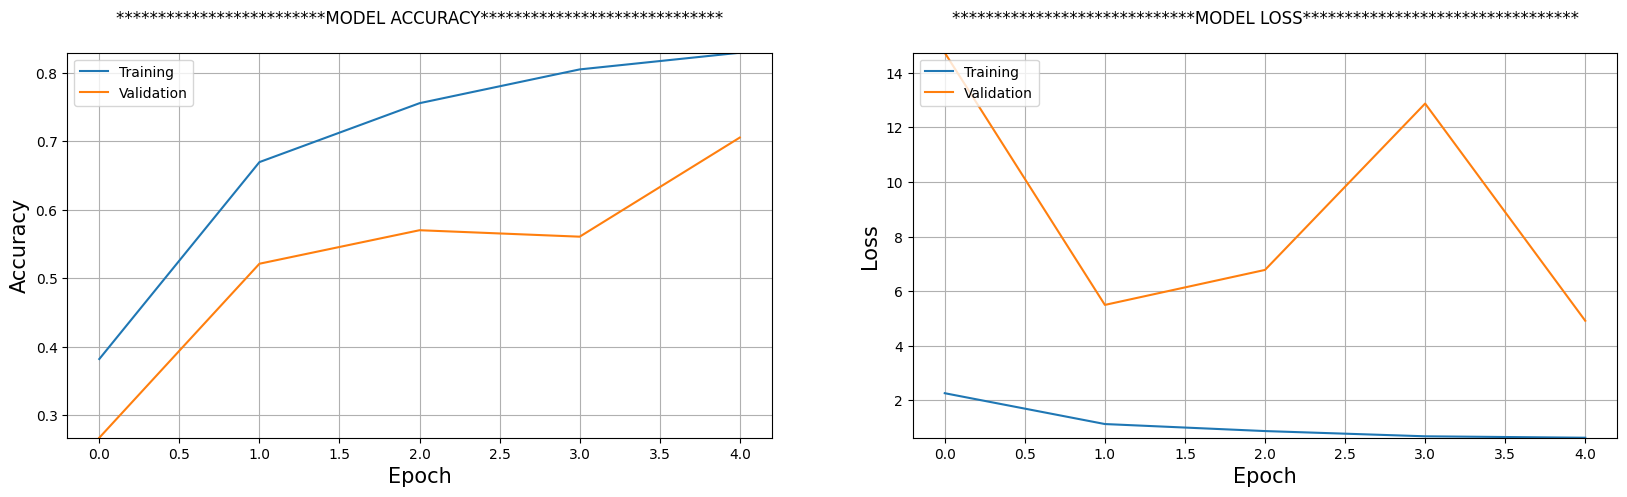

395/395 [==============================] - 4s 8ms/step
************************************Model Accuracy*******************************************
0.6951702296120348


In [14]:
# Building the MobileNetV2 Model
mobile_mv2_model = tf.keras.models.Sequential([
    MobileNetV2(weights='imagenet', include_top=False, input_tensor=None,
    classes=43,
    pooling=None, classifier_activation='softmax', input_shape=X_train.shape[1:]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(43, activation='softmax')
])

# Compilation of model
mobile_mv2_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Model Overview
mobile_mv2_model.summary()

# Training(Fitting) the Model
with tf.device('/GPU:0'):
    epochs = 5
    mv2_history = mobile_mv2_model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))
plot_performance(history = mv2_history)
predict_test_data(mobile_mv2_model)

1/1 [==============================] - 0s 409ms/step
********************************************MobileNetV2 Model**************************************************
Predicted traffic sign is:  Yield


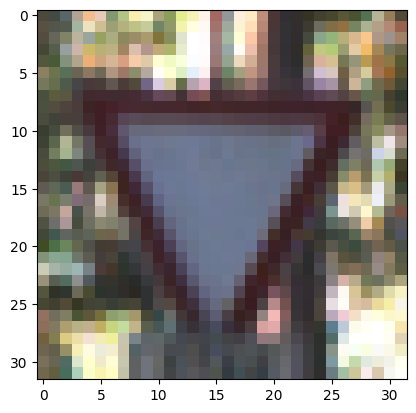

In [15]:
# Calling function to test the image
plot,prediction = test_on_img(r'/content/gtsrb-german-traffic-sign/Test/00026.png', mobile_mv2_model)
s = [str(i) for i in prediction] 
a = int("".join(s)) 
print("********************************************MobileNetV2 Model**************************************************")
print("Predicted traffic sign is: ", classes[a])
plt.imshow(plot)
plt.show()